In [3]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 41.0 MB/s eta 0:00:00


In [4]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
## Enivronment defined in part 1

class GridEnvironment1(gym.Env):
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10


    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.obs_pos1 = [1,3]
        self.obs_pos2 = [2,0]
        self.interm_pos1 = [3,2]
        self.interm_pos2 = [0,1]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.obs_pos1)] = 0.4
        self.state[tuple(self.obs_pos2)] = 0.3
        self.state[tuple(self.interm_pos1)] = 0.7
        self.state[tuple(self.interm_pos2)] = 0.5
        self.state[tuple(self.goal_pos)] = 0.8
        self.reward = 0 
        observation = np.ravel_multi_index(self.agent_pos, (4, 4))
        info = {}

        return observation,info
    
    def step(self,action):

      if action==0:
        self.agent_pos[0] +=1 ## Down
      elif action==1:
        self.agent_pos[0] -=1 ## UP
      elif action==2:
        self.agent_pos[1] +=1 ## Right
      elif action==3:
        self.agent_pos[1] -=1 ## Left
      ## cliffing to the boundary
      self.agent_pos = np.clip(self.agent_pos, 0, 3)
      self.state = np.zeros((4,4))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.8
      observation = np.ravel_multi_index(self.agent_pos, (4, 4))
      

      reward = 0
      
      if(self.agent_pos==self.goal_pos).all():
        reward += 10
      elif(self.agent_pos==self.obs_pos1).all():
        reward -=5
        self.timestep += 1
      elif(self.agent_pos==self.obs_pos2).all():
        reward -=3
        self.timestep += 1
      elif(self.agent_pos==self.interm_pos1).all():
        reward += 6
      elif(self.agent_pos==self.interm_pos2).all():
        reward += 4

      terminated = True if self.timestep >= self.max_timesteps or (self.agent_pos == self.goal_pos).all() else False
      truncated = True if np.all((self.agent_pos >= 0) & (self.agent_pos <= 3)) else False

      info = {}

      return  observation ,reward , terminated , truncated , info
    

    def render(self):
      plt.figure()
      plt.imshow(self.state)
      plt.show()

## Implementing Q - learning 

In [6]:
import random

def q_learning(env, num_episodes, alpha, gamma, epsilon, decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    max_reward = 0
    epsilon_ep = []
    
    for i in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        terminated = False
        
        while not terminated:
            action = epsilon_greedy(q_table, state, env.action_space.n, epsilon)

            next_state, reward, terminated, _, _ = env.step(action)

            q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])

            total_reward += reward
            state = next_state
        
        rewards.append(total_reward)

        if total_reward > max_reward:
            max_reward = total_reward
        
        if epsilon > 0:
            epsilon-= epsilon * decay_rate
        epsilon_ep.append(epsilon)

    print("Maximum reward obtained: {}".format(max_reward))
    
    return q_table, rewards, epsilon_ep

def epsilon_greedy(q_table, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(q_table[state, :])

    return action


Maximum reward obtained: 4352


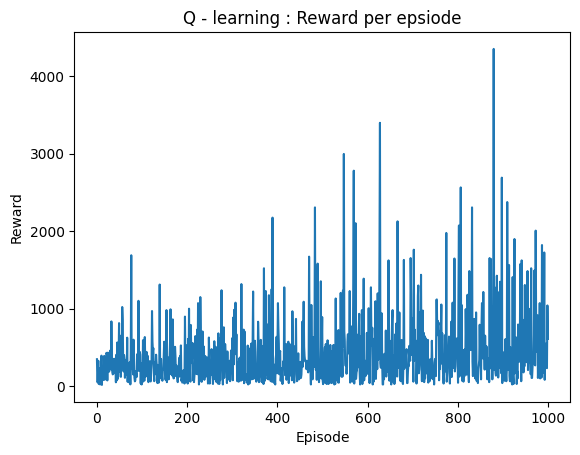

In [ ]:
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env,1000, 0.1, 0.99, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

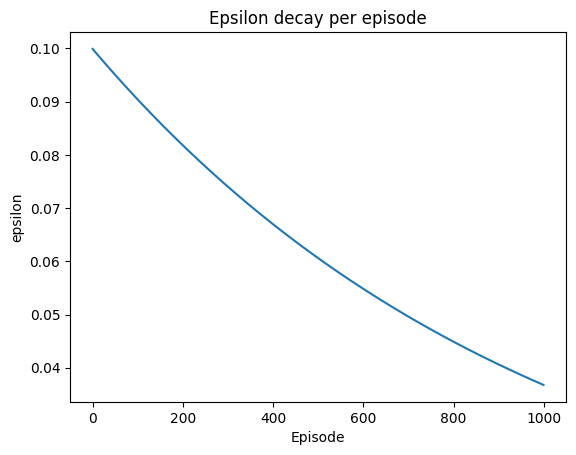

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

In [ ]:
print(q_table)

[[ 2.16539891e+02  4.65956678e+02  5.80357606e+02  5.07522306e+02]
 [ 5.82179400e+02  4.96930220e+02  3.66858310e+02  4.73519907e+02]
 [ 4.99278650e+02  3.29484201e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.70000000e-01  5.10714017e+02  0.00000000e+00  4.12948143e-01]
 [ 5.88060000e+02  4.46480478e+02  4.85663380e+02  2.71333954e+02]
 [ 5.92432035e+02  2.03628074e+01 -5.00000000e-01  5.82179400e+01]
 [ 3.40461000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.22756879e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.94000000e+02  4.13219892e+02  5.41316123e+02  2.09370379e+02]
 [ 6.00000000e+02  4.52292456e+02  4.00032941e+00  4.50618897e+02]
 [ 7.71232075e+00  0.00000000e+00  4.63873410e-01  0.00000000e+00]
 [ 0.00000000e+00  2.66867880e+00  5.89816049e+02  8.37526913e+01]
 [ 5.52875793e+02  5.79140386e+02  6.00000000e+02  5.29565665e+02]
 [ 6.00000000e+02  5.94000000e+02  1.00000000e+01  5.94000000e

## Hyper paramter tunning

# Tunning alpha

Maximum reward obtained: 3272


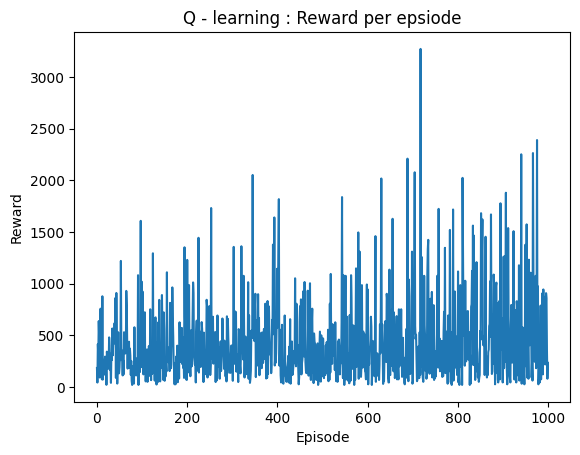

In [ ]:
## changing alpha to 0.01
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.01, 0.99, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

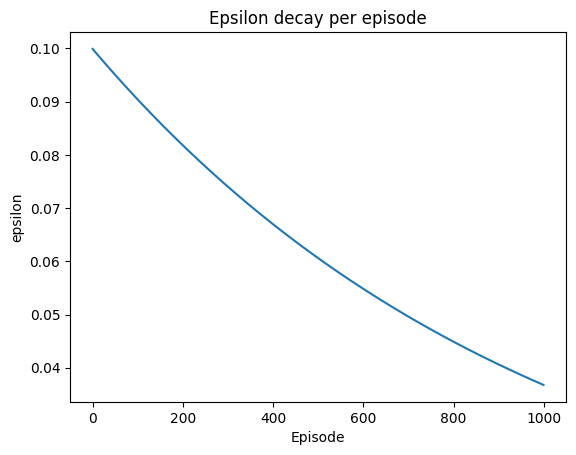

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

Maximum reward obtained: 60938


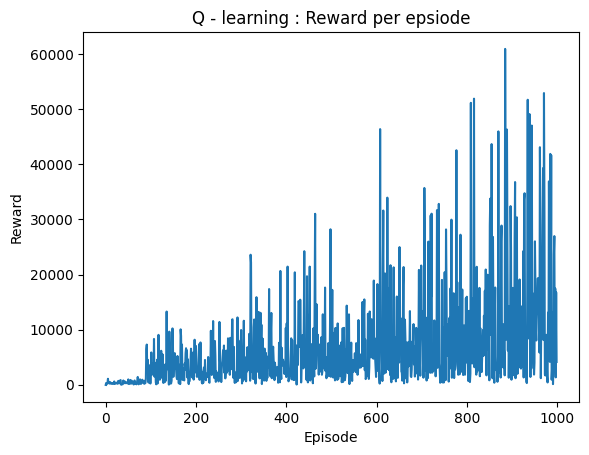

In [ ]:
## changing alpha to 0.001
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.99, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

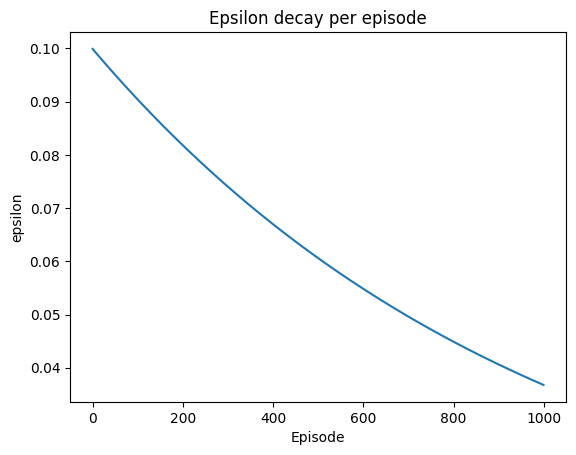

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

## tunning Disscount factor  -- gaama
# taking aplha=0.001, epsilon = 0.1 , num_episodes = 1000, decay_rate=0.001 , gaama = 0.5

Maximum reward obtained: 80381


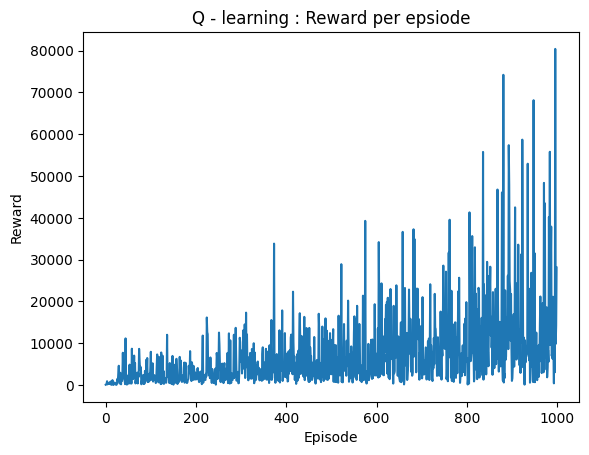

In [ ]:
## changing gaama to 0.5
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.5, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

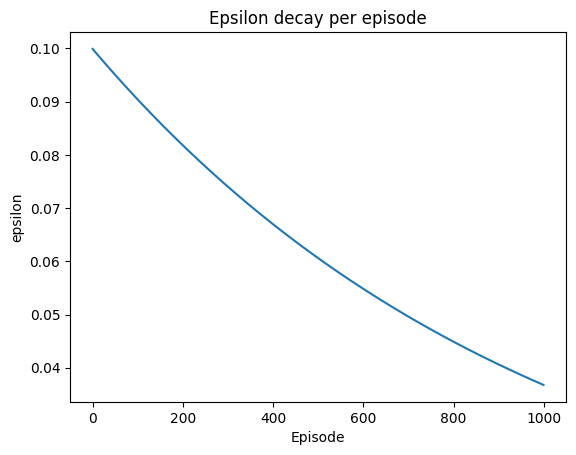

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

Maximum reward obtained: 3790


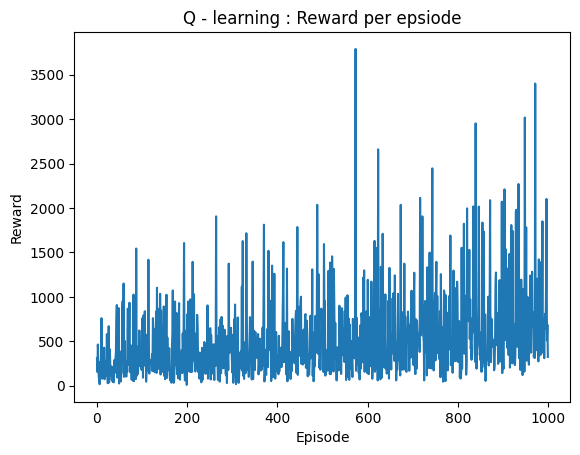

In [ ]:
## changing gaama to 0.7
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.7, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

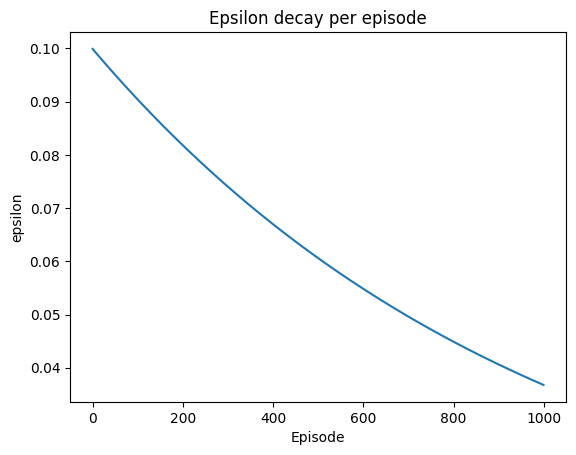

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

Maximum reward obtained: 154746


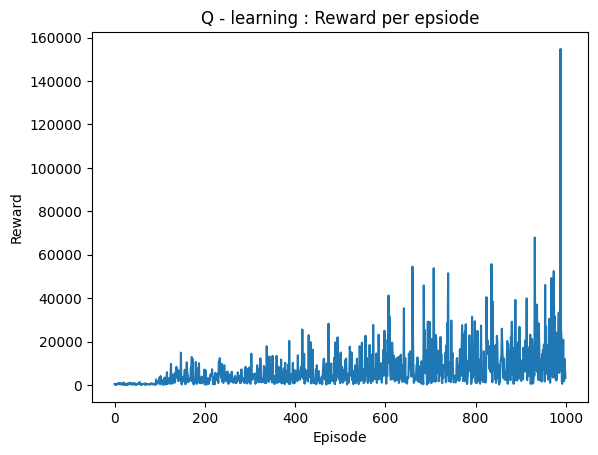

In [ ]:
## changing gaama to 0.9
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.9, 0.1,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

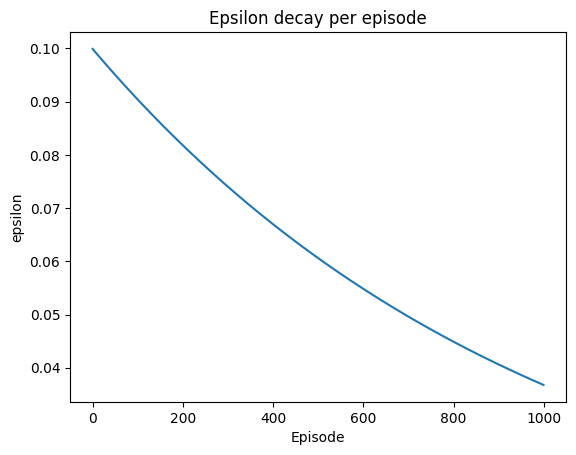

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

## Tunning epsilon
# tsking alpha=0.001 , num_episodes = 1000 , gaama = 0.5 , decay_rate= 0.001

Maximum reward obtained: 5048


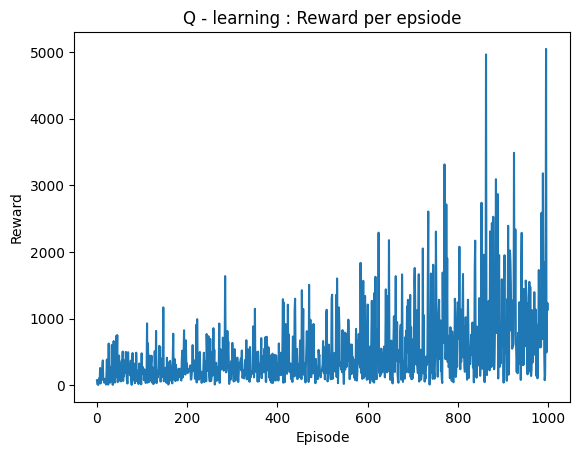

In [ ]:
## changing epsilon = 0.5
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.5, 0.5,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

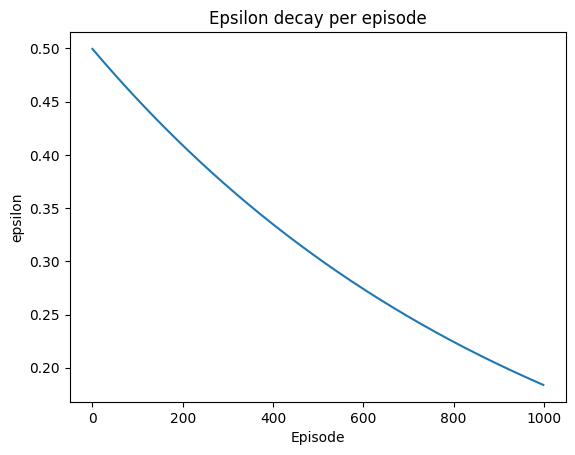

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

Maximum reward obtained: 2058


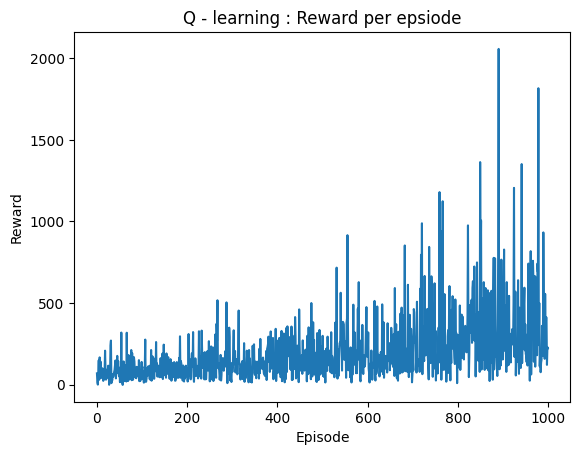

In [ ]:
## changing epsilon = 0.7
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.5, 0.7,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

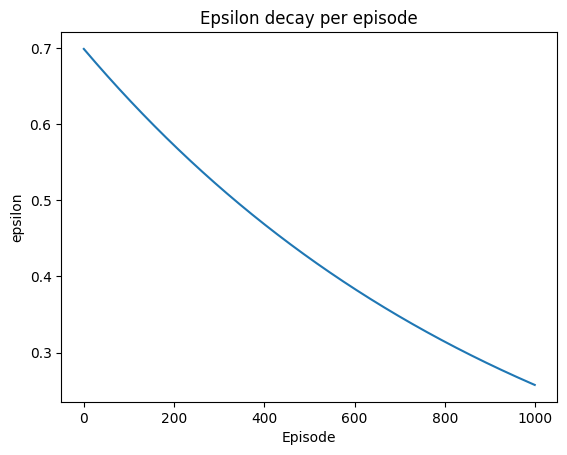

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

Maximum reward obtained: 1902


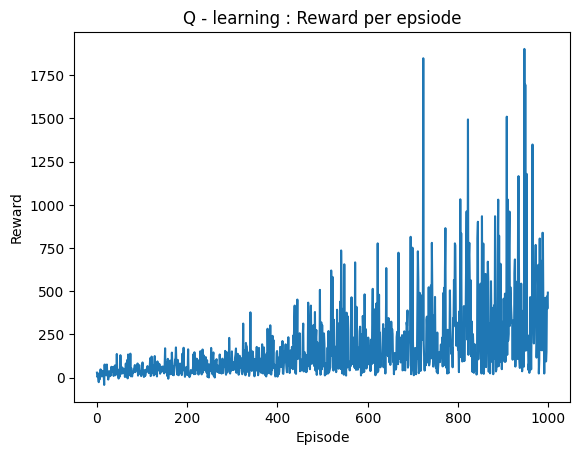

In [ ]:
## changing epsilon = 0.9
import matplotlib.pyplot as plt

env = GridEnvironment1()
q_table, rewards , epsilon_ep = q_learning(env, 1000, 0.001, 0.5, 0.9,0.001)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q - learning : Reward per epsiode')
plt.show()

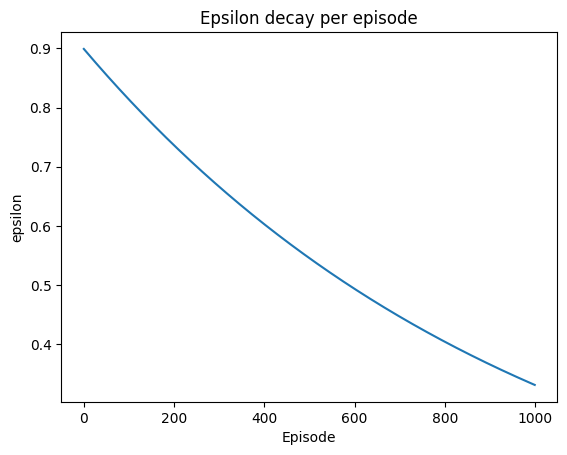

In [ ]:
plt.plot(epsilon_ep)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('Epsilon decay per episode')
plt.show()

## Using sarsa from part 2 to compare it with the q learning

In [7]:
import random
def sarsa(env, num_episodes, alpha, gamma, epsilon,decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    max_reward=0
    epsilon_ep=[]
    
    for i in range(num_episodes):
        state,_ = env.reset()

        action = epsilon_greedy(q_table, state, env.action_space.n, epsilon)
        total_reward = 0
        terminated = False
        
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)

            next_action= epsilon_greedy(q_table, next_state, env.action_space.n, epsilon)
            q_table[state, action] += alpha * (reward + gamma *  q_table[next_state,next_action] - q_table[state, action])
            total_reward += reward
            state = next_state
            action = next_action
        
        rewards.append(total_reward)

        if total_reward > max_reward:
            max_reward = total_reward
        
        if epsilon > 0:
            epsilon -= epsilon * decay_rate
        epsilon_ep.append(epsilon)

        
    
    print("Maximum reward obtained: {}".format(max_reward))
    
    return q_table, rewards,epsilon_ep

def epsilon_greedy(q_table, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        action = np.random.randint(num_actions)
    else:

        action = np.argmax(q_table[state, :])

        
    return action

In [9]:
env = GridEnvironment1()
q_table, rewards_sarsa , epsilon_ep = sarsa(env, 1000, 0.001, 0.9, 0.7,0.001)

Maximum reward obtained: 8628


In [10]:
q_table, rewards_qlearning , epsilon_ep = q_learning(env, 1000, 0.001, 0.5, 0.9,0.001)

Maximum reward obtained: 1258


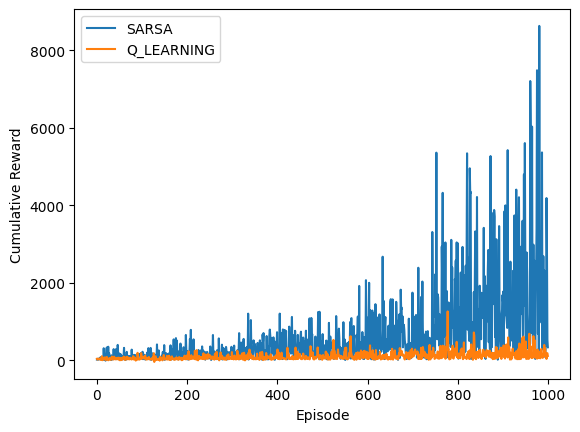

In [11]:
plt.plot(rewards_sarsa, label='SARSA')
plt.plot(rewards_qlearning, label='Q_LEARNING')

# Add labels and a legend
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

# Show the plot
plt.show()